In [ ]:
 import os

os.environ['KAGGLE_USERNAME'] = 'brainmentors'
os.environ['KAGGLE_KEY'] = '338041484874c1bb492dd5fe1f133e1e'

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 600M/612M [00:04<00:00, 137MB/s]
100% 612M/612M [00:04<00:00, 138MB/s]


In [ ]:
!unzip gtsrb-german-traffic-sign.zip

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

In [ ]:
train_df = pd.read_csv('Train.csv')

In [ ]:
train_df.shape

(39209, 8)

In [ ]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [ ]:
def load_data(df):
  images = []
  labels = []

  for i in range(len(df)):
    img = Image.open(df['Path'].iloc[i])
    img = img.resize((28,28))
    images.append(np.array(img))
    labels.append(df['ClassId'].iloc[i])

  return images, labels

In [ ]:
train_images, train_labels = load_data(train_df)

In [ ]:
test_df = pd.read_csv('Test.csv')
test_images, test_labels = load_data(test_df)

In [ ]:
x_train = np.asarray(train_images)
x_test = np.asarray(test_images)

In [ ]:
x_train.shape

(39209, 28, 28, 3)

In [ ]:
x_test.shape

(12630, 28, 28, 3)

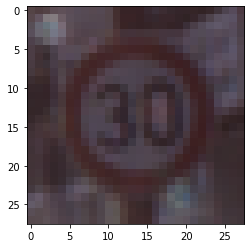

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[2000])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train_labels = np.reshape(train_labels, (-1,1))
encoder = OneHotEncoder()
y_train = encoder.fit_transform(train_labels).toarray()

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x_train, x_test = x_train/255.0, x_test/255.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

In [ ]:
train_df = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_df = tf.data.Dataset.from_tensor_slices((x_test, test_labels)).shuffle(10000).batch(32)

In [ ]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32,3,padding='same', activation='relu')
    self.pool1 = MaxPooling2D((2,2))
    self.conv2 = Conv2D(64,3,padding='same', activation='relu')
    self.pool2 = MaxPooling2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(256, activation='relu')
    self.dense2 = Dense(128, activation='relu')
    self.dense3 = Dense(43, activation="softmax")

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [ ]:
model = MyModel()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name = 'train_acc')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients((zip(gradients, model.trainable_variables)))

  train_loss(loss)
  train_acc(labels, predictions)

In [ ]:
epochs = 5
for epoch in range(epochs):
  for images, labels in train_df:
    train_step(images, labels)
  
  model.save_weights('/content', save_format='tf')

  print("Epochs : ",epoch, "Loss :",train_loss.result(), "Accuracy :",train_acc.result())
  train_loss.reset_states()
  train_acc.reset_states()

Epochs :  0 Loss : tf.Tensor(0.9465075, shape=(), dtype=float32) Accuracy : tf.Tensor(0.72465503, shape=(), dtype=float32)
Epochs :  1 Loss : tf.Tensor(0.11350985, shape=(), dtype=float32) Accuracy : tf.Tensor(0.9678645, shape=(), dtype=float32)
Epochs :  2 Loss : tf.Tensor(0.051563516, shape=(), dtype=float32) Accuracy : tf.Tensor(0.9850035, shape=(), dtype=float32)
Epochs :  3 Loss : tf.Tensor(0.031677898, shape=(), dtype=float32) Accuracy : tf.Tensor(0.9907419, shape=(), dtype=float32)
Epochs :  4 Loss : tf.Tensor(0.025222003, shape=(), dtype=float32) Accuracy : tf.Tensor(0.9919661, shape=(), dtype=float32)
